# Installation

In [3]:
!pip3 install python-chess
!pip3 install cairosvg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 1.8 MB/s 
     |████████████████████████████████| 88 kB 4.4 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=7fb3d4710fe7dcefc888ca82882d56c8fc82fba6b9dfca33219d3dcdf2f7b1ce
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


# Import

In [4]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import random
import hashlib
import copy
import chess
import chess.svg
import cairosvg
from cairosvg import svg2png
import cv2
from google.colab.patches import cv2_imshow
import chess
import chess.svg
from IPython.display import clear_output

# Monte Carlo Tree Search

In [ ]:
class MCTS:

    def __init__(self, c=1.414):
        self.w = defaultdict(int)  # total reward of each node
        self.n = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.c = c # exploration parameter

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        def score(n):
            if self.n[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.w[n] / self.n[n]  # average reward

        if node.is_finished():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        return max(self.children[node], key=score)

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.w[n] / self.n[n] + self.c * math.sqrt(math.log(self.n[node]) / self.n[n])

        return max(self.children[node], key=uct)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _rollout(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        invert_reward = True
        while True:
            #print('re')
            if node.is_finished():
                #print('terminal')
                reward = node.reward()
                return (1 - reward) if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.n[node] += 1
            self.w[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    def mcts_simulate(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._rollout(leaf)
        self._backpropagate(path, reward)

In [ ]:
class ChessGame():
  def __init__(self, board):
    self.board = board

  def find_children(self):
    if self.is_finished():
      return set()

    return{
        self.push_move(m) for m in self.board.legal_moves
    }

  def find_random_child(self):
    if self.is_finished():
      return None

    moves = list(self.board.legal_moves)
    m = random.choice(moves)
    return self.push_move(m)

  def player_win(self, turn):
    if self.board.result() == '1-0' and turn:
      return True

    if self.board.result() == '0-1' and not turn:
      return True

    return False

  def reward(self):
    if self.board.result() == '1/2-1/2':
      return 0.5

    if self.player_win(not self.board.turn):
      return 0.0

  def push_move(self, move):
    child = self.board.copy()
    child.push(move)
    return ChessGame(child)

  def is_finished(self):
    return self.board.is_game_over()

# Minimax

# Utils

In [7]:
def write_and_show_board(current_board):
  board_img = chess.svg.board(current_board, flipped = False)
  svg2png(bytestring=board_img,write_to='/content/board.png')
  img = cv2.imread('/content/board.png', 1)
  cv2_imshow(img)

In [ ]:
def play_chess_human_MCTS():
  tree = MCTS()
  game = ChessGame(chess.Board())
  write_and_show_board(game.board)
  count = 0
  print("Number of moves: ", count)
  while True:
    while True:
      move_str = input("Enter your move: ")
      move = chess.Move.from_uci(move_str)
      if move in list(game.board.legal_moves):
        game = game.push_move(move)
        break
      else:
        print("Invalid move")      
    clear_output()   
    write_and_show_board(game.board)
    count += 1
    print("Number of moves: ", count)    
    if game.is_finished():
      if game.board.is_stalemate():
        print("Draw")
      if game.board.is_checkmate():
        print("You win")
      break
   
    print("Please wait AI to make the decision...")
    for _ in range(50):
      tree.mcts_simulate(game)
    game = tree.choose(game)   
    clear_output()
    write_and_show_board(game.board)
    count += 1
    print("Number of moves: ", count)
    if game.is_finished():
      if game.board.is_stalemate():
        print("Draw")
      if game.board.is_checkmate():
        print("AI wins")
      break

# Test

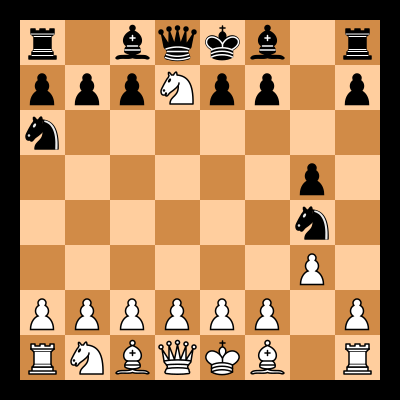

Number of moves:  8


KeyboardInterrupt: ignored

In [ ]:
play_chess_human_MCTS()

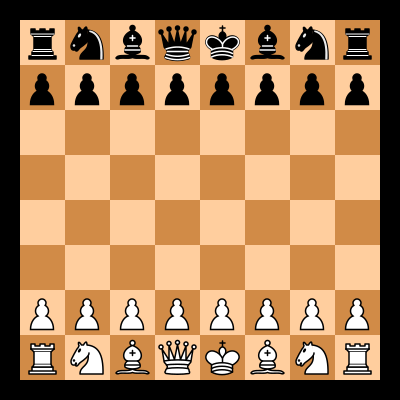

In [8]:
current_board = chess.Board()
write_and_show_board(current_board)